<a href="https://colab.research.google.com/github/yankyerajoseph/yankyerajoseph/blob/main/Appendix_2_Kinetic_Modelling_of_MCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from google.colab import files

#Read csv data relating to b. Biogas yield data in ml/ g oTS for fibrous materials (YCPM: MCP, MPP)
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/SummaryofBY/DSFibrous.csv'
cleaned_data = data.dropna()
print ("Biogas yield of three variants of fibrous waste in ml/g oTS: YCPM: Milled mixture of Yam, Cassava, Plantain Peels, MCP: Milled Cassava Peels, MPP: Milled Plantain Peels")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Biogas yield of three variants of fibrous waste in ml/g oTS: YCPM: Milled mixture of Yam, Cassava, Plantain Peels, MCP: Milled Cassava Peels, MPP: Milled Plantain Peels


In [ ]:
from scipy.stats import t
from scipy.optimize import curve_fit # Import curve_fit

# Define the logistic model function
def logistic_model(t, P0, um, lambd):
  """
  Logistic growth model for biogas production.

  Args:
    t: Time (days).
    P0: Maximum biogas potential (ml/g oTS).
    um: Maximum specific biogas production rate (day⁻¹).
    lambd: Lag phase period (days).

  Returns:
    Cumulative biogas production at time t.
  """
  return P0 / (1 + np.exp(um * (lambd - t)))


# Extract and filter data for the first 40 days HRT for MCP
time_data = data['HRT (d)'].values
biogas_data_mcp = data['Biogas Yield of MCP (ml/g oTS)'].values

mask_40 = time_data <= 40
time_data_40 = time_data[mask_40]
biogas_data_mcp_40 = biogas_data_mcp[mask_40]


# Define initial guesses for Logistic model parameters
# Based on visual inspection of the 40-day MCP data
max_biogas_40 = biogas_data_mcp_40.max() # Use max for 40 days
P0_init_logistic = max_biogas_40 * 1.1 # Slightly higher than max observed
um_init_logistic = 0.5 # Rate constant
lambda_init_logistic = 1.0 # Lag phase

# Fit the logistic_model
params_logistic, covariance_logistic = curve_fit(
    logistic_model,
    time_data_40,
    biogas_data_mcp_40,
    p0=[P0_init_logistic, um_init_logistic, lambda_init_logistic],
    maxfev=50000
)

# Calculate standard errors for Logistic model
perr_logistic = np.sqrt(np.diag(covariance_logistic))

# Calculate 95% confidence intervals for Logistic model
alpha = 0.05  # 95% confidence level (already defined)
n_40 = len(time_data_40) # Number of data points (using 40-day data length)
p_logistic = len(params_logistic) # Number of parameters
dof_logistic = n_40 - p_logistic # Degrees of freedom
t_crit_logistic = np.abs(t.ppf(alpha/2, dof_logistic)) # t-critical value

ci_logistic = (params_logistic - t_crit_logistic * perr_logistic, params_logistic + t_crit_logistic * perr_logistic)


print("Fitted parameters for Logistic model:", params_logistic)
print("Standard errors for Logistic model:", perr_logistic)
print("95% Confidence intervals for Logistic model:", ci_logistic)

Fitted parameters for Logistic model: [216.95071615   1.54886921   1.31356359]
Standard errors for Logistic model: [2.45398775 0.18594555 0.06724995]
95% Confidence intervals for Logistic model: (array([211.90647209,   1.16665267,   1.17532933]), array([221.9949602 ,   1.93108576,   1.45179785]))


In [ ]:
# Assume 'data' DataFrame is already loaded and contains 'HRT (d)' and 'Biogas Yield of MCP (ml/g oTS)'

time_data = data['HRT (d)'].values
biogas_data_mcp = data['Biogas Yield of MCP (ml/g oTS)'].values

mask_19 = time_data <= 19
time_data_19 = time_data[mask_19]
biogas_data_mcp_19 = biogas_data_mcp[mask_19]

print("Time data for MCP (<= 19 days):")
print(time_data_19)
print("\nBiogas data for MCP (<= 19 days):")
print(biogas_data_mcp_19)

Time data for MCP (<= 19 days):
[ 0.    0.79  0.95  1.08  1.65  1.88  2.7   3.69  3.89  4.83  5.75  6.78
  8.05 10.04 11.94 12.99 13.88 15.08 17.79]

Biogas data for MCP (<= 19 days):
[  0.    43.71  87.17 112.05 149.06 152.54 170.72 191.61 202.06 206.05
 212.76 217.01 219.98 222.43 222.04 221.66 221.66 221.27 220.62]


In [ ]:
from scipy.optimize import curve_fit
from scipy.stats import t
import numpy as np

# Define the new Hybrid model (50% First-order + 50% Modified Gompertz)
def hybrid_50_50_model(t, P0_fo, k_fo, P0_mg, um_mg, lambda_mg):
  """
  Hybrid kinetic model combining 50% First-order and 50% Modified Gompertz.

  Args:
    t: Time (days).
    P0_fo: Maximum biogas potential for First-order part (ml/g oTS).
    k_fo: Rate constant for First-order part (day⁻¹).
    P0_mg: Maximum biogas potential for Modified Gompertz part (ml/g oTS).
    um_mg: Maximum specific biogas production rate for Modified Gompertz part (mL/g oTS/day).
    lambda_mg: Lag phase period for Modified Gompertz part (days).

  Returns:
    Cumulative biogas production at time t.
  """
  # First-order model component
  biogas_fo = P0_fo * (1 - np.exp(-k_fo * t))

  # Modified Gompertz model component
  # Ensure the exponential term inside the outer exp is handled for small or negative values of (t - lambda_mg)
  exponent_mg = um_mg * np.e / P0_mg * (lambda_mg - t)
  biogas_mg = P0_mg * np.exp(-np.exp(exponent_mg + 1)) # Adding 1 to match the standard form some places use

  # Combine the two components with a 50/50 weighting
  return 0.5 * biogas_fo + 0.5 * biogas_mg


# Assume time_data_19 and biogas_data_mcp_19 are already defined

# Define initial guesses for the new Hybrid model parameters
# The new hybrid model has 5 parameters: P0_fo, k_fo, P0_mg, um_mg, lambda_mg
# We can base initial guesses on the previous fits of the individual models to the 40-day data,
# adjusting for the 19-day range if necessary.

# Initial guesses for First-order part
P0_init_fo_hybrid = biogas_data_mcp_19.max() * 0.5 # Half of max biogas for the first part
k_init_fo_hybrid = 0.5 # Rate constant

# Initial guesses for Modified Gompertz part
P0_init_mg_hybrid = biogas_data_mcp_19.max() * 0.5 # Half of max biogas for the second part
um_init_mg_hybrid = 30 # Max specific rate
lambda_init_mg_hybrid = 0.2 # Lag phase

initial_guesses_hybrid_50_50 = [P0_init_fo_hybrid, k_init_fo_hybrid, P0_init_mg_hybrid, um_init_mg_hybrid, lambda_init_mg_hybrid]


# Fit the hybrid_50_50_model
params_hybrid_50_50, covariance_hybrid_50_50 = curve_fit(
    hybrid_50_50_model,
    time_data_19,
    biogas_data_mcp_19,
    p0=initial_guesses_hybrid_50_50,
    maxfev=50000
)

# Calculate standard errors for the new Hybrid model
perr_hybrid_50_50 = np.sqrt(np.diag(covariance_hybrid_50_50))

# Calculate 95% confidence intervals for the new Hybrid model
alpha = 0.05  # 95% confidence level (already defined)
n_19 = len(time_data_19) # Number of data points (using 19-day data length)
p_hybrid_50_50 = len(params_hybrid_50_50) # Number of parameters
dof_hybrid_50_50 = n_19 - p_hybrid_50_50 # Degrees of freedom

# Ensure degrees of freedom are non-negative
if dof_hybrid_50_50 < 0:
    print("Warning: Degrees of freedom is negative. Confidence intervals may not be meaningful.")
    t_crit_hybrid_50_50 = np.nan # Cannot calculate t-critical
    ci_hybrid_50_50 = (np.full_like(params_hybrid_50_50, np.nan), np.full_like(params_hybrid_50_50, np.nan))
else:
    t_crit_hybrid_50_50 = np.abs(t.ppf(alpha/2, dof_hybrid_50_50)) # t-critical value
    ci_hybrid_50_50 = (params_hybrid_50_50 - t_crit_hybrid_50_50 * perr_hybrid_50_50, params_hybrid_50_50 + t_crit_hybrid_50_50 * perr_hybrid_50_50)


print("Fitted parameters for new Hybrid (50/50) model:", params_hybrid_50_50)
print("Standard errors for new Hybrid (50/50) model:", perr_hybrid_50_50)
print("95% Confidence intervals for new Hybrid (50/50) model:", ci_hybrid_50_50)

Fitted parameters for new Hybrid (50/50) model: [3.12249572e+02 4.39199596e-01 1.34269058e+02 5.09146068e+02
 8.23578102e-01]
Standard errors for new Hybrid (50/50) model: [1.61712215e+01 2.41374588e-02 1.66530082e+01 1.08198472e+02
 4.56035501e-02]
95% Confidence intervals for new Hybrid (50/50) model: (array([277.5657511 ,   0.3874299 ,  98.55190772, 277.08342422,
         0.72576821]), array([3.46933392e+02, 4.90969297e-01, 1.69986208e+02, 7.41208711e+02,
       9.21387989e-01]))


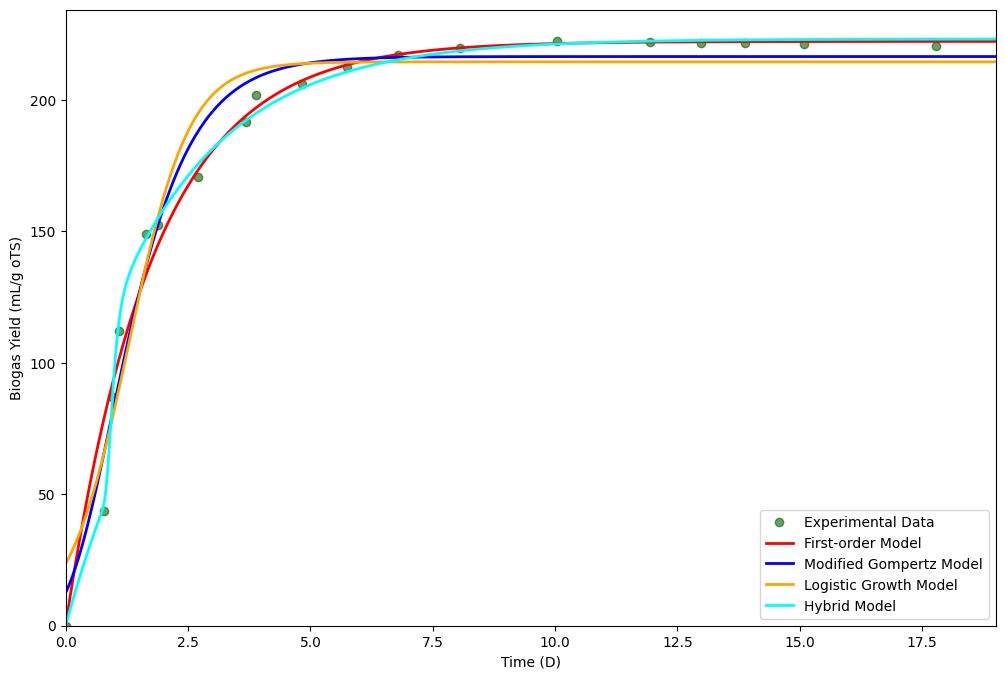

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume time_data_19, biogas_data_mcp_19 are already defined
# Assume params_fo_19, params_mg_19, params_hybrid_19, params_logistic_19, params_hybrid_50_50 are already defined
# Assume model functions are already defined (first_order_model, modified_gompertz_model, hybrid_model, logistic_model, hybrid_50_50_model)

# Generate time points for plotting the fitted curves (up to 19 days)
time_model_19 = np.linspace(0, 19, 600)

# Calculate biogas production values for each model using parameters fitted to 19-day data
biogas_model_fo_19 = first_order_model(time_model_19, *params_fo_19)
biogas_model_mg_19 = modified_gompertz_model(time_model_19, *params_mg_19)
# biogas_model_hybrid_19 = hybrid_model(time_model_19, *params_hybrid_19) # Removed Two-Phase Exponential
biogas_model_logistic_19 = logistic_model(time_model_19, *params_logistic_19)
biogas_model_hybrid_50_50 = hybrid_50_50_model(time_model_19, *params_hybrid_50_50)


# Create the plot
plt.figure(figsize=(12, 8))

# Plot experimental data (up to 19 days)
plt.plot(time_data_19, biogas_data_mcp_19, 'o', label="Experimental Data", color='darkgreen', alpha=0.6)

# Plot fitted curves for all models
plt.plot(time_model_19, biogas_model_fo_19, '-', label=f"First-order Model", color='red', linewidth=2)
plt.plot(time_model_19, biogas_model_mg_19, '-', label=f"Modified Gompertz Model", color='blue', linewidth=2)
# plt.plot(time_model_19, biogas_model_hybrid_19, '-', label=f"Two-Phase Exponential Model", color='purple', linewidth=2) # Removed Two-Phase Exponential plot
plt.plot(time_model_19, biogas_model_logistic_19, '-', label=f"Logistic Growth Model", color='orange', linewidth=2) # Label changed to Logistic Growth Model
plt.plot(time_model_19, biogas_model_hybrid_50_50, '-', label=f"Hybrid Model", color='cyan', linewidth=2) # Label changed to Hybrid (FO + MG)


# Add labels
plt.xlabel("Time (D)")
plt.ylabel("Biogas Yield (mL/g oTS)")
plt.legend(loc='lower right')
plt.grid(False)

# Set axis limits to start from origin and limit to 19 days
plt.xlim(0, 19)
plt.ylim(0)

# Save plot as TIFF BEFORE showing it
plt.savefig('MCP_kinetic_models_19days_revised.tif', dpi=600, format='tif') # Changed filename to indicate revision

plt.show()

In [ ]:
# Define the First-order model function
def first_order_model(t, P0, k):
    """
    First-order kinetic model for biogas production.

    Args:
      t: Time (days).
      P0: Maximum biogas potential (ml/g oTS).
      k: Rate constant (day⁻¹).

    Returns:
      Cumulative biogas production at time t.
    """
    return P0 * (1 - np.exp(-k * t))

# Define the Modified Gompertz model function
def modified_gompertz_model(t, P0, um, lambd):
    """
    Modified Gompertz kinetic model for biogas production.

    Args:
      t: Time (days).
      P0: Maximum biogas potential (ml/g oTS).
      um: Maximum specific biogas production rate (ml/g oTS/day).
      lambd: Lag phase period (days).

    Returns:
      Cumulative biogas production at time t.
    """
    # Avoid issues with log(0) or division by zero by adding a small epsilon
    return P0 * np.exp(-np.exp(um * np.e / (P0 + 1e-9) * (lambd - t) + 1))


# Define the Logistic model function
def logistic_model(t, P0, um, lambd):
  """
  Logistic growth model for biogas production.

  Args:
    t: Time (days).
    P0: Maximum biogas potential (ml/g oTS).
    um: Maximum specific biogas production rate (day⁻¹).
    lambd: Lag phase period (days).

  Returns:
    Cumulative biogas production at time t.
  """
  return P0 / (1 + np.exp(um * (lambd - t)))

In [ ]:
# Assume time_data_19 and biogas_data_mcp_19 are already defined

# Fit the First-order model to 19-day data
# Initial guesses for First-order model
P0_init_fo = biogas_data_mcp_19.max()
k_init_fo = 0.1
params_fo_19, covariance_fo_19 = curve_fit(first_order_model, time_data_19, biogas_data_mcp_19, p0=[P0_init_fo, k_init_fo], maxfev=50000)

# Fit the Modified Gompertz model to 19-day data
# Initial guesses for Modified Gompertz model
P0_init_mg = biogas_data_mcp_19.max()
um_init_mg = 10
lambda_init_mg = 0.5
params_mg_19, covariance_mg_19 = curve_fit(modified_gompertz_model, time_data_19, biogas_data_mcp_19, p0=[P0_init_mg, um_init_mg, lambda_init_mg], maxfev=50000)

# Fit the Logistic model to 19-day data
# Initial guesses for Logistic model
P0_init_logistic = biogas_data_mcp_19.max() * 1.1
um_init_logistic = 0.5
lambda_init_logistic = 1.0
params_logistic_19, covariance_logistic_19 = curve_fit(logistic_model, time_data_19, biogas_data_mcp_19, p0=[P0_init_logistic, um_init_logistic, lambda_init_logistic], maxfev=50000)

# Note: params_hybrid_19 and covariance_hybrid_19 are for the Two-Phase Exponential Model
# The Two-Phase Exponential Model is not being plotted in cell 4_mhgCyqUJ_O
# If you need to fit the Two-Phase Exponential Model to 19-day data, you'll need to define that function and fit it here as well.

In [ ]:
from google.colab import files

# Assuming the latest plot saved is 'MCP_kinetic_models_19days_revised.tif'
file_name = 'MCP_kinetic_models_19days_revised.tif'

try:
    files.download(file_name)
    print(f"Downloaded: {file_name}")
except FileNotFoundError:
    print(f"Error: File not found - {file_name}. Please ensure the cell that generates this file has been executed.")
except Exception as e:
    print(f"An error occurred while downloading {file_name}: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: MCP_kinetic_models_19days_revised.tif


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error # Import necessary evaluation metrics

# Evaluate the new Hybrid model (50% First-order + 50% Modified Gompertz)
biogas_model_eval_hybrid_50_50 = hybrid_50_50_model(time_data_19, *params_hybrid_50_50) # Use 19-day data for evaluation
r2_hybrid_50_50 = r2_score(biogas_data_mcp_19, biogas_model_eval_hybrid_50_50) # Use 19-day data for evaluation
rmse_hybrid_50_50 = np.sqrt(mean_squared_error(biogas_data_mcp_19, biogas_model_eval_hybrid_50_50))

print(f"New Hybrid Model (50/50) (19 days) - R-squared: {r2_hybrid_50_50:.4f}, RMSE: {rmse_hybrid_50_50:.4f}")

# Print fitted equations for all models (19 days)
print("\nFitted Model Equations (19 days HRT):")

# First-order model equation
print(f"First-order Model: B(t) = {params_fo_19[0]:.2f} * (1 - exp(-{params_fo_19[1]:.2f} * t))")

# Modified Gompertz model equation
print(f"Modified Gompertz Model: B(t) = {params_mg_19[0]:.2f} * exp(-exp({params_mg_19[1]:.2f} * np.e / {params_mg_19[0]:.2f} * ({params_mg_19[2]:.2f} - t) + 1))")

# Hybrid model equation (Two-Phase Exponential) - Using parameters fitted to 19-day data
# Removed as per plot update
# print(f"Two-Phase Exponential Model: B(t) = {params_hybrid_19[0]:.2f} * (1 - exp(-{params_hybrid_19[2]:.2f} * (t - {params_hybrid_19[4]:.2f}))) * (t >= {params_hybrid_19[4]:.2f}) + {params_hybrid_19[1]:.2f} * (1 - exp(-{params_hybrid_19[3]:.2f} * (t - {params_hybrid_19[5]:.2f}))) * (t >= {params_hybrid_19[5]:.2f})")

# Logistic model equation
print(f"Logistic Growth Model: B(t) = {params_logistic_19[0]:.2f} / (1 + exp({params_logistic_19[1]:.2f} * ({params_logistic_19[2]:.2f} - t)))")

# New Hybrid model equation (50% First-order + 50% Modified Gompertz)
print(f"Hybrid Model: B(t) = 0.5 * ({params_hybrid_50_50[0]:.2f} * (1 - exp(-{params_hybrid_50_50[1]:.2f} * t))) + 0.5 * ({params_hybrid_50_50[2]:.2f} * exp(-exp({params_hybrid_50_50[3]:.2f} * np.e / {params_hybrid_50_50[2]:.2f} * ({params_hybrid_50_50[4]:.2f} - t) + 1)))")


New Hybrid Model (50/50) (19 days) - R-squared: 0.9984, RMSE: 2.5867

Fitted Model Equations (19 days HRT):
First-order Model: B(t) = 222.33 * (1 - exp(-0.56 * t))
Modified Gompertz Model: B(t) = 216.57 * exp(-exp(88.54 * np.e / 216.57 * (0.04 - t) + 1))
Logistic Growth Model: B(t) = 214.56 / (1 + exp(1.62 * (1.29 - t)))
Hybrid Model: B(t) = 0.5 * (312.25 * (1 - exp(-0.44 * t))) + 0.5 * (134.27 * exp(-exp(509.15 * np.e / 134.27 * (0.82 - t) + 1)))


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# Assume time_data_19 and biogas_data_mcp_19 are already defined
# Assume params_fo_19, params_mg_19, params_logistic_19, params_hybrid_50_50, params_hybrid_19 are already defined
# Assume model functions are already defined (first_order_model, modified_gompertz_model, logistic_model, hybrid_50_50_model, hybrid_model)


print("Model Evaluation Metrics (19 days HRT for MCP):")

# Evaluate First-order model (19 days)
biogas_model_eval_fo_19 = first_order_model(time_data_19, *params_fo_19)
r2_fo_19 = r2_score(biogas_data_mcp_19, biogas_model_eval_fo_19)
rmse_fo_19 = np.sqrt(mean_squared_error(biogas_data_mcp_19, biogas_model_eval_fo_19))
print(f"First-order Model - R-squared: {r2_fo_19:.4f}, RMSE: {rmse_fo_19:.4f}")

# Evaluate Modified Gompertz model (19 days)
biogas_model_eval_mg_19 = modified_gompertz_model(time_data_19, *params_mg_19)
r2_mg_19 = r2_score(biogas_data_mcp_19, biogas_model_eval_mg_19)
rmse_mg_19 = np.sqrt(mean_squared_error(biogas_data_mcp_19, biogas_model_eval_mg_19))
print(f"Modified Gompertz Model - R-squared: {r2_mg_19:.4f}, RMSE: {rmse_mg_19:.4f}")

# Evaluate Logistic model (19 days)
biogas_model_eval_logistic_19 = logistic_model(time_data_19, *params_logistic_19)
r2_logistic_19 = r2_score(biogas_data_mcp_19, biogas_model_eval_logistic_19)
rmse_logistic_19 = np.sqrt(mean_squared_error(biogas_data_mcp_19, biogas_model_eval_logistic_19))
print(f"Logistic Growth Model - R-squared: {r2_logistic_19:.4f}, RMSE: {rmse_logistic_19:.4f}")

# Evaluate Hybrid (50/50) model (19 days)
biogas_model_eval_hybrid_50_50_19 = hybrid_50_50_model(time_data_19, *params_hybrid_50_50)
r2_hybrid_50_50_19 = r2_score(biogas_data_mcp_19, biogas_model_eval_hybrid_50_50_19)
rmse_hybrid_50_50_19 = np.sqrt(mean_squared_error(biogas_data_mcp_19, biogas_model_eval_hybrid_50_50_19))
print(f"Hybrid Model (50/50) - R-squared: {r2_hybrid_50_50_19:.4f}, RMSE: {rmse_hybrid_50_50_19:.4f}")

# Evaluate Hybrid (Two-Phase Exponential) model (19 days)
biogas_model_eval_hybrid_19 = hybrid_model(time_data_19, *params_hybrid_19)
r2_hybrid_19 = r2_score(biogas_data_mcp_19, biogas_model_eval_hybrid_19)
rmse_hybrid_19 = np.sqrt(mean_squared_error(biogas_data_mcp_19, biogas_model_eval_hybrid_19))
print(f"Hybrid (Two-Phase Exponential) Model - R-squared: {r2_hybrid_19:.4f}, RMSE: {rmse_hybrid_19:.4f}")

Model Evaluation Metrics (19 days HRT for MCP):
First-order Model - R-squared: 0.9783, RMSE: 9.6116
Modified Gompertz Model - R-squared: 0.9746, RMSE: 10.4003
Logistic Growth Model - R-squared: 0.9604, RMSE: 12.9808
Hybrid Model (50/50) - R-squared: 0.9984, RMSE: 2.5867
Hybrid (Two-Phase Exponential) Model - R-squared: 0.9918, RMSE: 5.8935
